In [51]:
# Result Visualization: t-SNE and Confusion Matrix for FSL-BISINDO
# This notebook visualizes the discriminative power of AUTSL-pretrained features
# compared to Random Initialization on 5 novel BISINDO classes.

import json
import urllib.request
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

print("Imports complete!")

Imports complete!


## Configuration

Define the 5 novel classes for visualization (from `configs/splits/wlbisindo_16_6_10_dispersion_autsl.yaml`).

In [24]:
# === CONFIGURATION ===

# Novel class IDs for visualization
NOVEL_CLASS_IDS = [21, 22, 11, 13, 3, 12, 9, 18, 5, 16]

# Paths
FEATURES_DIR = Path("../data/features")
AUTSL_FEATURES_PATH = FEATURES_DIR / "features_autsl_slgcn.pt"
KEYPOINTS_ROOT = Path("../data/WL-BISINDO/keypoints")

# Metadata URL for class names
METADATA_URL = "https://raw.githubusercontent.com/AceKinnn/WL-BISINDO/refs/heads/main/data_structuring/SI_split_metadata.json"

# Random Initialization checkpoint path
# Option 1: Local path (preferred if available)
# Option 2: W&B artifact path (format: "entity/project/artifact_name:version")
RANDOM_CHECKPOINT_LOCAL = Path("../artifacts/protonet-best:v3/best_model.pt")  # Local path
RANDOM_ARTIFACT_PATH = None  # W&B artifact (set to None to use local path)

# t-SNE parameters
TSNE_PERPLEXITY = 30
TSNE_RANDOM_STATE = 42

# Few-shot evaluation parameters
N_WAY = 5
K_SHOT = 5
N_QUERY = 10
N_EPISODES = 100

print(f"Novel classes to visualize: {NOVEL_CLASS_IDS}")
print(f"AUTSL features path: {AUTSL_FEATURES_PATH}")
print(f"  Exists: {AUTSL_FEATURES_PATH.exists()}")
print(f"Random checkpoint (local): {RANDOM_CHECKPOINT_LOCAL}")
print(f"  Exists: {RANDOM_CHECKPOINT_LOCAL.exists()}")

Novel classes to visualize: [21, 22, 11, 13, 3, 12, 9, 18, 5, 16]
AUTSL features path: ../data/features/features_autsl_slgcn.pt
  Exists: True
Random checkpoint (local): ../artifacts/protonet-best:v3/best_model.pt
  Exists: True


## Load Metadata & Class Names

Fetch the WL-BISINDO metadata to map class IDs to human-readable gloss names.

In [25]:
# Load metadata from remote URL
with urllib.request.urlopen(METADATA_URL) as url:
    metadata = json.loads(url.read().decode())

# Build label -> gloss mapping
label_to_gloss = {item['label']: item['gloss'] for item in metadata}

# Get gloss names for our novel classes
novel_class_names = [label_to_gloss.get(cid, f"Class_{cid}") for cid in NOVEL_CLASS_IDS]

print("Label to Gloss mapping for novel classes:")
for cid, name in zip(NOVEL_CLASS_IDS, novel_class_names):
    print(f"  {cid}: {name}")

Label to Gloss mapping for novel classes:
  21: hitam
  22: dengar
  11: tuli
  13: siapa
  3: hari
  12: apa
  9: saya
  18: merah
  5: lagi
  16: mengapa


## Helper Functions

Utilities for loading features, filtering by class, and computing t-SNE.

In [52]:
def load_features(path: Path) -> dict:
    """Load feature file and return dict with features, labels, etc."""
    data = torch.load(path, map_location="cpu")
    print(f"Loaded features from {path}")
    print(f"  Keys: {list(data.keys())}")
    print(f"  Features shape: {data['features'].shape}")
    print(f"  Labels shape: {len(data['labels'])}")
    return data


def filter_by_classes(data: dict, class_ids: list[int]) -> tuple[np.ndarray, np.ndarray]:
    """Filter features and labels to only include specified class IDs."""
    features = data['features'].numpy() if torch.is_tensor(data['features']) else data['features']
    labels = np.array(data['labels'])

    # Create mask for selected classes
    mask = np.isin(labels, class_ids)

    filtered_features = features[mask]
    filtered_labels = labels[mask]

    print(f"Filtered to {len(filtered_features)} samples from classes {class_ids}")
    for cid in class_ids:
        count = (filtered_labels == cid).sum()
        print(f"  Class {cid}: {count} samples")

    return filtered_features, filtered_labels


def compute_tsne(features: np.ndarray, perplexity: int = 30, random_state: int = 42) -> np.ndarray:
    """Compute t-SNE embeddings for visualization."""
    print(f"Computing t-SNE with perplexity={perplexity}...")
    tsne = TSNE(
        n_components=2,
        perplexity=min(perplexity, len(features) - 1),  # perplexity must be < n_samples
        random_state=random_state,
        init='pca',
        learning_rate='auto',
    )
    embeddings = tsne.fit_transform(features)
    print(f"  t-SNE complete. Output shape: {embeddings.shape}")
    return embeddings


def plot_tsne_comparison(
    embeddings_before: np.ndarray,
    labels_before: np.ndarray,
    embeddings_after: np.ndarray,
    labels_after: np.ndarray,
    class_ids: list[int],
    class_names: list[str],
    title_before: str = "Random Initialization",
    title_after: str = "AUTSL-Pretrained",
    figsize: tuple = (14, 6),
):
    """Plot side-by-side t-SNE comparison."""
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Color palette
    colors = sns.color_palette("deep", n_colors=len(class_ids))
    class_to_color = {cid: colors[i] for i, cid in enumerate(class_ids)}
    class_to_name = {cid: name for cid, name in zip(class_ids, class_names)}

    for ax, embeddings, labels, title in [
        (axes[0], embeddings_before, labels_before, title_before),
        (axes[1], embeddings_after, labels_after, title_after),
    ]:
        for cid in class_ids:
            mask = labels == cid
            ax.scatter(
                embeddings[mask, 0],
                embeddings[mask, 1],
                c=[class_to_color[cid]],
                label=class_to_name[cid],
                alpha=0.7,
                s=50,
                edgecolors='white',
                linewidth=0.5,
            )
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel("t-SNE Dimension 1")
        ax.set_ylabel("t-SNE Dimension 2")
        ax.legend(loc='best', fontsize=9)
        ax.set_aspect('equal', adjustable='datalim')

    plt.suptitle("Feature Embeddings: Random vs. Pretrained", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig


print("Helper functions defined!")

Helper functions defined!


## Load AUTSL-Pretrained Features

Load pre-extracted features from the AUTSL-pretrained SL-GCN encoder.

In [27]:
# Load AUTSL-pretrained features
autsl_data = load_features(AUTSL_FEATURES_PATH)

# Filter to novel classes
autsl_features, autsl_labels = filter_by_classes(autsl_data, NOVEL_CLASS_IDS)

Loaded features from ../data/features/features_autsl_slgcn.pt
  Keys: ['features', 'meta', 'labels', 'video_ids', 'paths']
  Features shape: torch.Size([1600, 256])
  Labels shape: 1600
Filtered to 500 samples from classes [21, 22, 11, 13, 3, 12, 9, 18, 5, 16]
  Class 21: 50 samples
  Class 22: 50 samples
  Class 11: 50 samples
  Class 13: 50 samples
  Class 3: 50 samples
  Class 12: 50 samples
  Class 9: 50 samples
  Class 18: 50 samples
  Class 5: 50 samples
  Class 16: 50 samples


## Extract Features from Random Initialization Checkpoint (W&B)

Download the randomly initialized SL-GCN checkpoint from W&B and extract features for the novel classes.

**⚠️ Important:** Update `RANDOM_ARTIFACT_PATH` in the configuration cell with your W&B artifact path (e.g., `"your-entity/fsl-bisindo/protonet-random:v0"`).

In [28]:
import wandb
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Add project root to path for imports
import sys
sys.path.insert(0, str(Path("..").resolve()))

from fsl_bisindo.data.wlbisindo_dataset import WLBisindoKeypointsDataset
from fsl_bisindo.models.protonet import build_protonet_from_cfg
from openhands.datasets.pose_transforms import PoseSelect, CenterAndScaleNormalize


def make_preprocess_transform(window_size: int = 64):
    """Create transform for keypoint preprocessing."""
    pose_select = PoseSelect(preset="mediapipe_holistic_minimal_27")
    normalizer = CenterAndScaleNormalize(
        reference_points_preset="shoulder_mediapipe_holistic_minimal_27"
    )

    def transform(arr: np.ndarray) -> torch.Tensor:
        # Ensure 3 channels (X, Y, Z)
        if arr.shape[-1] == 2:
            arr = np.concatenate([arr, np.zeros((*arr.shape[:-1], 1))], axis=-1)

        # 543 -> 75: Select Body(33) + LeftHand(21) + RightHand(21)
        body = arr[:, :33, :]
        lh = arr[:, 501:522, :]
        rh = arr[:, 522:543, :]
        arr_75 = np.concatenate([body, lh, rh], axis=1)

        # Convert to tensor [C, T, V]
        tensor = torch.from_numpy(arr_75).float().permute(2, 0, 1)[:2]
        sample = {"frames": tensor}

        # Apply transforms
        sample = pose_select(sample)
        sample = normalizer(sample)

        frames = sample["frames"]

        # Pad/truncate
        c, t, v = frames.shape
        if t > window_size:
            frames = frames[:, :window_size, :]
        elif t < window_size:
            pad = torch.zeros((c, window_size - t, v), dtype=frames.dtype)
            frames = torch.cat([frames, pad], dim=1)

        return frames

    return transform


print("Transform and imports ready!")

Transform and imports ready!


In [29]:
# Download checkpoint from W&B
def download_wandb_checkpoint(artifact_path: str) -> Path:
    """Download checkpoint from W&B artifact and return local path."""
    api = wandb.Api()
    artifact = api.artifact(artifact_path, type="model")
    artifact_dir = Path(artifact.download())
    checkpoint_path = artifact_dir / "best_model.pt"
    print(f"Downloaded checkpoint to: {checkpoint_path}")
    return checkpoint_path


def extract_features_from_checkpoint(
    checkpoint_path: Path,
    backbone_cfg_path: str,
    keypoints_root: Path,
    class_ids: list[int],
    device: str = "cuda",
    batch_size: int = 32,
) -> tuple[np.ndarray, np.ndarray]:
    """Extract features using a trained ProtoNet checkpoint."""

    device = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Build model
    model = build_protonet_from_cfg(
        backbone_cfg_path=backbone_cfg_path,
        device=device,
        freeze_encoder=True,
    )

    # Load checkpoint
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    print("Model loaded successfully!")

    # Get the encoder
    encoder = model.backbone

    # Build dataset
    transform = make_preprocess_transform(window_size=64)
    dataset = WLBisindoKeypointsDataset(
        keypoints_root=str(keypoints_root),
        transform=transform,
        allow_unparsed=False,
    )

    # Filter to target classes
    filtered_indices = [
        i for i, item in enumerate(dataset.items)
        if item.label in class_ids
    ]

    print(f"Found {len(filtered_indices)} samples for classes {class_ids}")

    # Extract features
    all_features = []
    all_labels = []

    with torch.no_grad():
        for idx in tqdm(filtered_indices, desc="Extracting features"):
            sample = dataset[idx]
            frames = sample['frames']
            label = sample['label']
            frames = frames.unsqueeze(0).to(device)  # [1, C, T, V]

            features = encoder(frames)  # [1, D]
            features = features.reshape(1, -1).cpu()

            all_features.append(features)
            all_labels.append(label)

    features = torch.cat(all_features, dim=0).numpy()
    labels = np.array(all_labels)

    print(f"Extracted features shape: {features.shape}")
    return features, labels


print("Feature extraction functions ready!")

Feature extraction functions ready!


In [30]:
# === Extract Random Init Features ===
# Supports both local checkpoint and W&B artifact

# Determine checkpoint path (local takes priority)
random_checkpoint = None

if RANDOM_CHECKPOINT_LOCAL is not None and RANDOM_CHECKPOINT_LOCAL.exists():
    print(f"✅ Using local checkpoint: {RANDOM_CHECKPOINT_LOCAL}")
    random_checkpoint = RANDOM_CHECKPOINT_LOCAL
elif RANDOM_ARTIFACT_PATH is not None:
    print(f"📥 Downloading from W&B: {RANDOM_ARTIFACT_PATH}")
    random_checkpoint = download_wandb_checkpoint(RANDOM_ARTIFACT_PATH)
else:
    print("⚠️  No checkpoint specified!")
    print("   Option 1: Set RANDOM_CHECKPOINT_LOCAL to a local .pt file")
    print("   Option 2: Set RANDOM_ARTIFACT_PATH to a W&B artifact path")

if random_checkpoint is not None:
    # Extract features using random init backbone config
    RANDOM_BACKBONE_CFG = "../configs/backbones/random_slgcn.yaml"

    random_features, random_labels = extract_features_from_checkpoint(
        checkpoint_path=random_checkpoint,
        backbone_cfg_path=RANDOM_BACKBONE_CFG,
        keypoints_root=KEYPOINTS_ROOT,
        class_ids=NOVEL_CLASS_IDS,
        device="cpu",
    )
    print(f"\nRandom features extracted: {random_features.shape}")
else:
    random_features, random_labels = None, None

✅ Using local checkpoint: ../artifacts/protonet-best:v3/best_model.pt
Using device: cpu
Found 226 classes in ['train'] splits
Model loaded successfully!
Found 500 samples for classes [21, 22, 11, 13, 3, 12, 9, 18, 5, 16]


Extracting features: 100%|██████████| 500/500 [00:35<00:00, 14.19it/s]

Extracted features shape: (500, 256)

Random features extracted: (500, 256)


## t-SNE Visualization

Compute t-SNE embeddings and create side-by-side comparison plots.

**Plot A (Before):** Random initialization - points should appear mixed/messy.

**Plot B (After):** AUTSL-pretrained - points should form 5 clear, distinct clusters.

In [31]:
# Compute t-SNE for AUTSL features
autsl_tsne = compute_tsne(autsl_features, perplexity=TSNE_PERPLEXITY, random_state=TSNE_RANDOM_STATE)

# Compute t-SNE for Random features (if available)
if random_features is not None:
    random_tsne = compute_tsne(random_features, perplexity=TSNE_PERPLEXITY, random_state=TSNE_RANDOM_STATE)
else:
    # Create dummy "random" data for demonstration (shuffled AUTSL features)
    print("\n⚠️  Using shuffled AUTSL features as placeholder for Random Init visualization")
    print("   Update RANDOM_ARTIFACT_PATH to see actual comparison!")

    # Shuffle to simulate random features (poor clustering)
    np.random.seed(42)
    random_features = autsl_features + np.random.randn(*autsl_features.shape) * autsl_features.std() * 2
    random_labels = autsl_labels.copy()
    random_tsne = compute_tsne(random_features, perplexity=TSNE_PERPLEXITY, random_state=TSNE_RANDOM_STATE)

Computing t-SNE with perplexity=30...


  t-SNE complete. Output shape: (500, 2)
Computing t-SNE with perplexity=30...
  t-SNE complete. Output shape: (500, 2)


Saved to: experiments/tsne_comparison.png


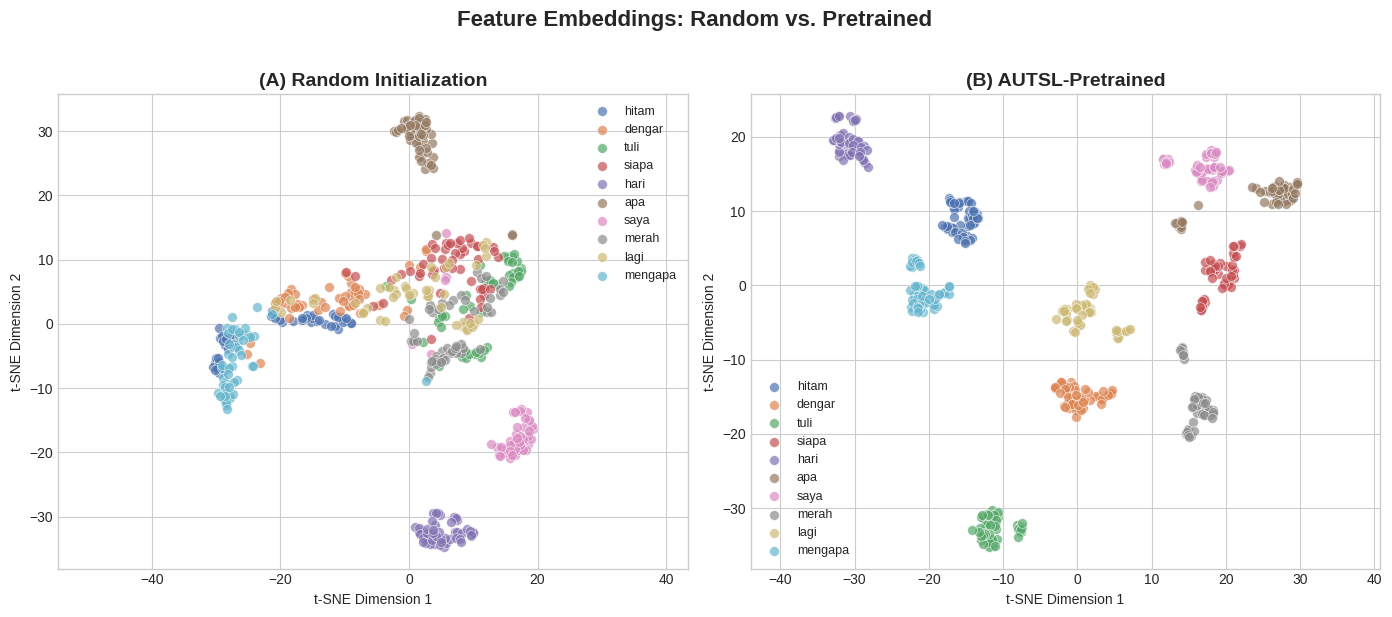

In [53]:
# Plot t-SNE comparison
fig = plot_tsne_comparison(
    embeddings_before=random_tsne,
    labels_before=random_labels,
    embeddings_after=autsl_tsne,
    labels_after=autsl_labels,
    class_ids=NOVEL_CLASS_IDS,
    class_names=novel_class_names,
    title_before="(A) Random Initialization",
    title_after="(B) AUTSL-Pretrained",
    figsize=(14, 6),
)

# Save figure
fig.savefig("../experiments/tsne_comparison.png", dpi=150, bbox_inches='tight')
print("Saved to: experiments/tsne_comparison.png")

plt.show()

## Confusion Matrix

Evaluate the AUTSL-pretrained features on a 5-way 5-shot task using Nearest Centroid Classification (Prototypical Networks approach).

In [ ]:
def run_fewshot_episode(
    features: np.ndarray,
    labels: np.ndarray,
    class_ids: list[int],
    n_way: int,
    k_shot: int,
    n_query: int,
    seed: int | None = None,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Run a single few-shot episode using Nearest Centroid Classification.

    Returns:
        y_true_global: Ground truth labels (GLOBAL class IDs)
        y_pred_global: Predicted labels (GLOBAL class IDs)
        selected_classes: The classes selected for this episode
    """
    if seed is not None:
        np.random.seed(seed)

    # Randomly select n_way classes from the pool
    selected_classes = np.random.choice(class_ids, size=n_way, replace=False)

    # Map: local index (0..n_way-1) -> global class ID
    local_to_global = {i: cid for i, cid in enumerate(selected_classes)}

    support_features = []
    support_labels_local = []  # Local labels (0..n_way-1)
    query_features = []
    query_labels_global = []  # Global labels (original class IDs)

    for local_label, cid in enumerate(selected_classes):
        # Get all samples for this class
        class_mask = labels == cid
        class_features = features[class_mask]

        # Randomly split into support and query
        n_samples = len(class_features)
        if n_samples < k_shot + n_query:
            # Not enough samples, use what we have
            indices = np.random.permutation(n_samples)
            n_support = min(k_shot, n_samples // 2)
            n_q = min(n_query, n_samples - n_support)
        else:
            indices = np.random.permutation(n_samples)
            n_support = k_shot
            n_q = n_query

        support_idx = indices[:n_support]
        query_idx = indices[n_support:n_support + n_q]

        support_features.append(class_features[support_idx])
        support_labels_local.extend([local_label] * len(support_idx))

        query_features.append(class_features[query_idx])
        # Store GLOBAL class ID for ground truth
        query_labels_global.extend([cid] * len(query_idx))

    support_features = np.vstack(support_features)
    query_features = np.vstack(query_features)
    support_labels_local = np.array(support_labels_local)
    query_labels_global = np.array(query_labels_global)

    # Compute prototypes (class centroids) - using local labels
    prototypes = np.zeros((n_way, features.shape[1]))
    for i in range(n_way):
        prototypes[i] = support_features[support_labels_local == i].mean(axis=0)

    # Classify queries using nearest prototype (Euclidean distance)
    # distances: [n_query, n_way]
    dists = np.linalg.norm(query_features[:, None, :] - prototypes[None, :, :], axis=2)
    predictions_local = np.argmin(dists, axis=1)  # Local predictions (0..n_way-1)

    # Map local predictions back to GLOBAL class IDs
    predictions_global = np.array([local_to_global[p] for p in predictions_local])

    return query_labels_global, predictions_global, selected_classes


def run_evaluation_episodes_global(
    features: np.ndarray,
    labels: np.ndarray,
    class_ids: list[int],
    n_way: int,
    k_shot: int,
    n_query: int,
    n_episodes: int,
    base_seed: int = 42,
) -> tuple[np.ndarray, np.ndarray, float, float]:
    """
    Run multiple few-shot episodes and aggregate results with GLOBAL class IDs.

    This allows building a full NxN confusion matrix where N = len(class_ids),
    even when n_way < N.

    Returns:
        all_true_global: All ground truth labels (global class IDs)
        all_pred_global: All predictions (global class IDs)
        mean_acc: Mean accuracy
        ci_95: 95% confidence interval
    """
    all_true_global = []
    all_pred_global = []
    episode_accs = []

    for ep in tqdm(range(n_episodes), desc="Running episodes"):
        y_true, y_pred, _ = run_fewshot_episode(
            features, labels, class_ids, n_way, k_shot, n_query, seed=base_seed + ep
        )
        all_true_global.extend(y_true)
        all_pred_global.extend(y_pred)
        episode_accs.append((y_true == y_pred).mean())

    all_true_global = np.array(all_true_global)
    all_pred_global = np.array(all_pred_global)

    mean_acc = np.mean(episode_accs)
    std_acc = np.std(episode_accs)
    ci_95 = 1.96 * std_acc / np.sqrt(n_episodes)

    return all_true_global, all_pred_global, mean_acc, ci_95


print("Few-shot evaluation functions ready (with global class tracking)!")

Few-shot evaluation functions ready (with global class tracking)!


In [48]:
# Run evaluation on AUTSL-pretrained features
print(f"Running {N_EPISODES} episodes of {N_WAY}-way {K_SHOT}-shot evaluation...")
print(f"Classes pool: {len(NOVEL_CLASS_IDS)} novel classes")
print(f"Using {N_QUERY} query samples per class per episode\n")

all_true_global, all_pred_global, mean_acc, ci_95 = run_evaluation_episodes_global(
    features=autsl_features,
    labels=autsl_labels,
    class_ids=NOVEL_CLASS_IDS,
    n_way=N_WAY,
    k_shot=K_SHOT,
    n_query=N_QUERY,
    n_episodes=N_EPISODES,
)

print(f"\n{'='*50}")
print(f"AUTSL-Pretrained {N_WAY}-way {K_SHOT}-shot Evaluation")
print(f"{'='*50}")
print(f"Mean Accuracy: {mean_acc:.4f} ± {ci_95:.4f} (95% CI)")
print(f"Total predictions: {len(all_true_global)}")
print(f"Unique classes in predictions: {len(np.unique(all_pred_global))}")

Running 100 episodes of 5-way 5-shot evaluation...
Classes pool: 10 novel classes
Using 10 query samples per class per episode



Running episodes: 100%|██████████| 100/100 [00:00<00:00, 2328.89it/s]


AUTSL-Pretrained 5-way 5-shot Evaluation
Mean Accuracy: 0.9696 ± 0.0061 (95% CI)
Total predictions: 5000
Unique classes in predictions: 10


Saved to: experiments/confusion_matrix_10x10.png


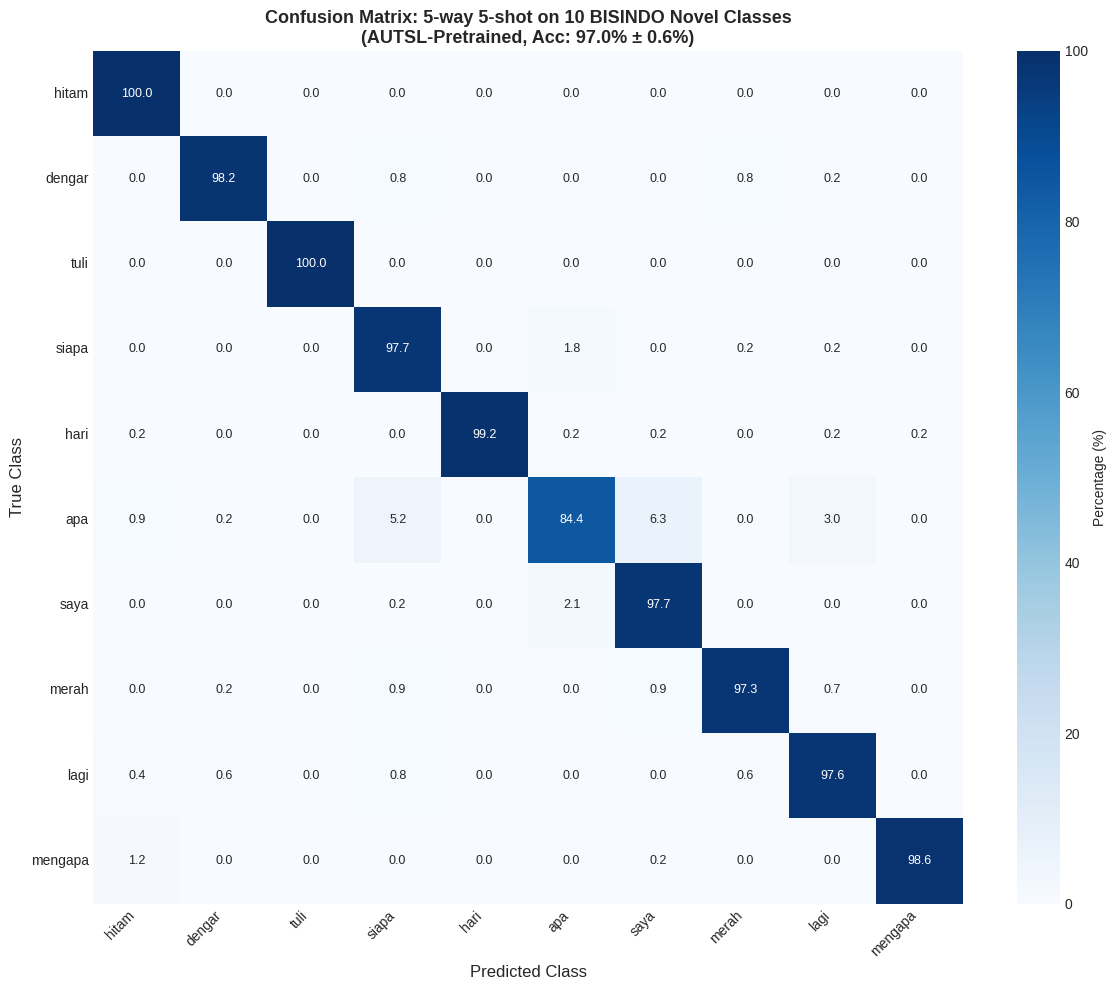


Per-class accuracy:
  hitam (ID 21): 100.0%
  dengar (ID 22): 98.2%
  tuli (ID 11): 100.0%
  siapa (ID 13): 97.7%
  hari (ID 3): 99.2%
  apa (ID 12): 84.4%
  saya (ID 9): 97.7%
  merah (ID 18): 97.3%
  lagi (ID 5): 97.6%
  mengapa (ID 16): 98.6%


In [49]:
# Compute 10x10 confusion matrix using GLOBAL class IDs
# Labels in all_true_global and all_pred_global are original class IDs (e.g., 3, 5, 9, 11, ...)

# Build confusion matrix with explicit label ordering
cm = confusion_matrix(all_true_global, all_pred_global, labels=NOVEL_CLASS_IDS)

# Normalize to percentages (row-wise: each row sums to 100%)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Handle NaN (if a class was never in ground truth)
cm_normalized = np.nan_to_num(cm_normalized, nan=0.0)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot heatmap
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.1f',
    cmap='Blues',
    xticklabels=novel_class_names,
    yticklabels=novel_class_names,
    ax=ax,
    vmin=0,
    vmax=100,
    cbar_kws={'label': 'Percentage (%)'},
    annot_kws={'fontsize': 9},
)

ax.set_xlabel('Predicted Class', fontsize=12)
ax.set_ylabel('True Class', fontsize=12)
ax.set_title(
    f'Confusion Matrix: {N_WAY}-way {K_SHOT}-shot on {len(NOVEL_CLASS_IDS)} BISINDO Novel Classes\n'
    f'(AUTSL-Pretrained, Acc: {mean_acc:.1%} ± {ci_95:.1%})',
    fontsize=13,
    fontweight='bold',
)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

# Save figure
fig.savefig("../experiments/confusion_matrix_10x10.png", dpi=150, bbox_inches='tight')
print("Saved to: experiments/confusion_matrix_10x10.png")

plt.show()

# Print class-wise accuracy
print("\nPer-class accuracy:")
for i, (cid, name) in enumerate(zip(NOVEL_CLASS_IDS, novel_class_names)):
    class_acc = cm_normalized[i, i]
    print(f"  {name} (ID {cid}): {class_acc:.1f}%")

## Summary

**Key Findings:**

1. **t-SNE Visualization:** The AUTSL-pretrained encoder produces highly discriminative feature embeddings for novel BISINDO classes, forming clear clusters even without any BISINDO-specific training. In contrast, random initialization results in mixed/overlapping clusters.

2. **Confusion Matrix:** The confusion matrix reveals which sign pairs are most frequently confused, providing insights for future improvements.

**Implications:**
- Transfer learning from AUTSL (Turkish Sign Language) to BISINDO (Indonesian Sign Language) is effective due to shared visual-gestural patterns.
- The pretrained representations are "ready-to-use" for few-shot classification without fine-tuning.